## 빅데이터 실습

### 다나와 무선청소기 상품분석

#### 데이터 수집

##### 셀레니움 사용

In [40]:
## 필수 라이브러리 사용등록
from selenium import webdriver
from bs4 import BeautifulSoup
from urllib import parse # url encode
from tqdm import tqdm
import pandas as pd
import time

In [41]:
## 웹드라이버로 크롬 오픈
driver = webdriver.Chrome()
url = r'https://search.danawa.com/dsearch.php?k1=%EC%97%90%EC%96%B4%EB%A9%94%EC%9D%B4%EB%93%9C+%EC%8A%A4%EB%A7%88%ED%8A%B8%ED%83%80%EC%9B%8C&module=goods&act=dispMain'
driver.get(url)
time.sleep(5.0)

In [42]:
html = driver.page_source
soup = BeautifulSoup(html, 'html.parser')

In [43]:
prodItems = soup.select('ul.product_list > li.prod_item')

In [44]:
len(prodItems)

3

In [45]:
prodItems[0].select('p.prod_name > a')[0].text.strip()

'에어메이드 스마트타워 AMC-3501A'

In [46]:
prodItems[0].select('div.spec_list')[0].text.strip().replace('\t', '')

'핸디스틱청소기 / 무선 / 흡입형 / 흡입력: 370W / 2024년형 / [구성] 먼지비움 / 충전 / UVC LED / 브러쉬: 바닥 / 침구 / 솔형 / 틈새 / 먼지봉투: 2.5L / [배터리] 사용시간: 40분(최대) / 충전시간: 5시간 / 분리형(1개) / 2500mAh / [청소] LED라이트 / BLDC모터 / [부가] 디스플레이표시 / 헤파필터 / 색상: 화이트 / 무게: 2.5kg / 크기(가로x세로x깊이): 252x1253x185mm'

In [47]:
# 만약에 수가 아닌 문자열 들어왔을때는 False
prodItems[0].select('input')[1].get('value').isdecimal()

True

##### 다나와 무선청소기 웹크롤링 다시
- 가격외에는 안들어오도록 변환

In [48]:
## 검색어, 페이지를 변경하면서 URL 생성함수
def getSearchPageUrl(keyword, page):
    ecKeyword = parse.quote(keyword)
    url = f'https://search.danawa.com/dsearch.php?query={ecKeyword}&originalQuery={ecKeyword}&previousKeyword={ecKeyword}&checkedInfo=N&volumeType=allvs&' + \
          f'page={page}&limit=120&sort=saveDESC&list=list&boost=true&tab=goods&addDelivery=N&coupangMemberSort=N&mode=simple&isInitTireSmartFinder=N&' + \
           'recommendedSort=N&defaultUICategoryCode=10325109&defaultPhysicsCategoryCode=72%7C80%7C81%7C0&defaultVmTab=3138&defaultVaTab=1098867&isZeroPrice=Y&' + \
           'quickProductYN=N&priceUnitSort=N&priceUnitSortOrder=A'
    return url

In [49]:
## 상품정보 추출하는 함수
def getProdItems(prodItems):
    prodData = []

    for prodItem in prodItems:
        try:
            prodName = prodItem.select('p.prod_name > a')[0].text.strip()  # 상품명 가져오기
            specList = prodItem.select('div.spec_list')[0].text.strip().replace('\t', '') # 상품 스펙목록 가져오기

            if prodItem.select('input')[1].get('value').isdecimal() == True: 
                price = prodItem.select('input')[1].get('value') # 최저가 가져오기
            else:
                price = 0 # 문자열 들어온 것 막음

            prodData.append([prodName, specList, price])
        except:
            pass
    
    return prodData

In [50]:
## 여러페이지 검색후 크롤링하는 작업
driver = webdriver.Chrome()
# 암묵적으로 웹 자원 로드를 위해 3초정도 대기
driver.implicitly_wait(3.0)

keyword = '무선청소기'
startPage = 1
totalPage = 20
prodDataTotal = [] # 최종적으로 저장할 리스트

for page in tqdm(range(startPage, totalPage +1)):
    # 검색 페이지 이동
    url = getSearchPageUrl(keyword, page)
    driver.get(url)
    # 페이지 로딩이 완료될때까지 5초간 대기
    time.sleep(5)

    # 현재 페이지 HTML 가져오기
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')

    # 상품정보 추출
    prodItems = soup.select('ul.product_list > li.prod_item')
    prodItemList = getProdItems(prodItems) # 리스트로 추출하는 함수

    # 추출된 정보를 prodDataTotal 추가
    prodDataTotal += prodItemList   

100%|██████████| 20/20 [04:00<00:00, 12.05s/it]


In [51]:
dfProdDataTotal = pd.DataFrame(prodDataTotal)

In [52]:
dfProdDataTotal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2120 entries, 0 to 2119
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       2120 non-null   object
 1   1       2120 non-null   object
 2   2       2120 non-null   object
dtypes: object(3)
memory usage: 49.8+ KB


In [53]:
dfProdDataTotal.columns = ['제품명','제품스펙','최저가']

In [54]:
dfProdDataTotal.to_excel('./data/다나와_무선청소기_결과.xlsx', index=False)

##### 크롤링 데이터 전처리

In [55]:
# 저장한 엑셀을 재로드
dfProdDanawa = pd.read_excel('./data/다나와_무선청소기_결과.xlsx')
dfProdDanawa.tail()

,제품명,제품스펙,최저가
2115,미니센 무선 소형 청소기 MNC-100 먼지통,차량용청소기 / 먼지통,7000
2116,프리라벨 2in1 무선 진공 청소기 LS-2000 헤파필터,차량용청소기 / 필터 / [필터] 헤파필터,3500
2117,상품상세설명 참조 캐치웰 텀블러 디자인 초경량 무선 핸디형 진공청소기_아이언그레이,NaN,0
2118,포쉬 워시젯 V2 WJ200,침구청소기 / 핸디형 / 무선 / 사용시간: 25분(최대) / [기능] 청소모드: ...,219000
2119,업킵 MJ-BC779,침구청소기 / 핸디형 / 무선 / [기능] 청소모드: UV살균 / 속도조절 / 헤파...,89900


In [56]:
dfProdDanawa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2120 entries, 0 to 2119
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   제품명     2120 non-null   object
 1   제품스펙    2110 non-null   object
 2   최저가     2120 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 49.8+ KB


In [57]:
dfProdDanawa.isnull().sum()

제품명      0
제품스펙    10
최저가      0
dtype: int64

In [58]:
# 결측치 검색
condition = dfProdDanawa['제품스펙'].isnull() == True

In [59]:
dfProdDanawa[condition]

,제품명,제품스펙,최저가
1846,스팀청소기 샤오미 무선 휴대용 자동차 진공 청소기 스마트 홈 흡입 및 블로잉 다기능...,NaN,0
1861,상품상세설명 참조 캐치웰 텀블러 디자인 초경량 무선 핸디형 진공청소기_아이언그레이,NaN,0
1910,스팀청소기 샤오미 무선 휴대용 자동차 진공 청소기 스마트 홈 흡입 및 블로잉 다기능...,NaN,0
1925,상품상세설명 참조 캐치웰 텀블러 디자인 초경량 무선 핸디형 진공청소기_아이언그레이,NaN,0
1974,스팀청소기 샤오미 무선 휴대용 자동차 진공 청소기 스마트 홈 흡입 및 블로잉 다기능...,NaN,0
1989,상품상세설명 참조 캐치웰 텀블러 디자인 초경량 무선 핸디형 진공청소기_아이언그레이,NaN,0
2038,스팀청소기 샤오미 무선 휴대용 자동차 진공 청소기 스마트 홈 흡입 및 블로잉 다기능...,NaN,0
2053,상품상세설명 참조 캐치웰 텀블러 디자인 초경량 무선 핸디형 진공청소기_아이언그레이,NaN,0
2102,스팀청소기 샤오미 무선 휴대용 자동차 진공 청소기 스마트 홈 흡입 및 블로잉 다기능...,NaN,0
2117,상품상세설명 참조 캐치웰 텀블러 디자인 초경량 무선 핸디형 진공청소기_아이언그레이,NaN,0


In [60]:
## 결측치가 있는 행(row)을 삭제
dfProdDanawa = dfProdDanawa.dropna(axis=0)

In [61]:
## 최저가가 0인 제품
condition = dfProdDanawa['최저가'] == 0

In [62]:
# 최저가가 0은 제품 제외한 나머지
dfProdDanawa = dfProdDanawa[condition == False]

In [63]:
# 행들이 삭제되면서 인덱스가 꼬임. 인덱스 초기화
dfProdDanawa.reset_index(drop=True, inplace=True)

In [64]:
# 결측치, 이상치를 제거한 최종 DF
# 회사명, 모델명, 카테고리, 사용시간, 흡입력 추출한 결과도 2057개가 필수
dfProdDanawa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2059 entries, 0 to 2058
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   제품명     2059 non-null   object
 1   제품스펙    2059 non-null   object
 2   최저가     2059 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 48.4+ KB


In [65]:
# 회사명, 제품명 분리 split(' ', n) n => 자를 공백의 번호
dfProdDanawa['제품명'][:5][0].split(' ', 1)

['LG전자', '오브제컬렉션 코드제로 A9S AX9884']

In [66]:
## 회사명, 모델명 분리 시작
compList = []
modelList = []
count = 0

for temp in dfProdDanawa['제품명']:
    titles = temp.split(' ', 1) # 길이 2 배열 생성
    if (len(titles) > 1):
        compList.append(titles[0]) # 회사명
        modelList.append(titles[1]) # 모델명
    else:
        compList.append('') # 회사명은 비운다
        modelList.append(titles[0]) # 모델명

    count +=1    

In [67]:
len(compList)

2059

In [68]:
len(modelList)

2059

In [69]:
# 스펙목록 데이터
specList = dfProdDanawa.loc[2000, '제품스펙'].split(' / ')

In [70]:
specList

['업소용청소기',
 '건습식',
 '무선',
 '흡입력: 16000Pa',
 '소비전력: 200W',
 '[기능] BLDC모터',
 '헤파필터',
 '먼지통',
 '충전시간: 3시간',
 '사용시간: 40분(최대)',
 '이동바퀴',
 '자동정지',
 '[부가] 탱크용량: 30L',
 '색상: 그린',
 '2023년형',
 '송풍',
 '배터리: 5000mAh, 21V',
 '배터리잔량표시',
 '구성: 건습식노즐, 소파브러쉬, 틈새노즐, 라운드브러쉬']

In [71]:
useTime = ''
suctionPow = ''
for spec in specList:
    if '사용시간' in spec:
        useTime = spec
    elif '흡입력' in spec:
        suctionPow = spec

print(useTime.split(' ')[1].strip())
print(suctionPow.split(' ')[1].strip()) # 흡입력이 없어서 ''경우는 split(' ')에서 예외발생

40분(최대)
16000Pa


In [72]:
dfProdDanawa.loc[0, '제품스펙']

'핸디스틱청소기 / 무선 / 흡입+물걸레(동시) / 흡입력: 250W / 소비전력: 620W / 2023년형 / [구성] 거치대: 올인원타워 / 먼지비움 / 충전 / UVC LED / 액서서리수납 / 스탠드거치 / 먼지비움시간: 30초 / 브러쉬: 와이드바닥 / 물걸레: 스팀, 고온, 일반 / 솔형 / 틈새 / 먼지봉투: 2.5L / [배터리] 사용시간: 30분(최대) / 충전시간: 4시간 / 분리형(2개) / 리튬이온 / 25.2V / [청소] 싸이클론흡입 / LED라이트 / 자동물공급 / 스마트인버터모터 / [부가] 스마트폰제어 / 대화형알림창 / 워셔블헤파필터 / 5단계여과 / 색상: 카밍베이지 / 무게: 2.47kg / 크기(가로x세로x깊이): 300x1120x245mm'

In [73]:
## 위의 테스트를 기반으로 카테고리, 사용시간, 흡입력 추출
categoryList = []
useTimeList = []
suctionPowList = []
count = 0

for spec in dfProdDanawa['제품스펙']:
    # ' / '로 문자열 분리
    specList = spec.split(' / ')
    # 카테고리 추출
    category = specList[0]
    categoryList.append(category)
    # 사용시간, 흡입력 추출
    useTimeVal = None
    suctionPowVal = None

    for temp in specList:
        if '사용시간' in temp:
            useTimeVal = temp.replace('[배터리] ', '') # 1. [배터리]가 값 오류 발생시킴
        elif '흡입력' in temp:
            suctionPowVal = temp

    # 끝난 다음에도 사용시간, 흡입력이 None이면 스펙에 찾을값이 없었음
    if useTimeVal != None:
        useTime = useTimeVal.split(' ')[1].strip().replace('(최대)', '') # 2. (최대) 삭제
    else:
        useTime = ''

    if suctionPowVal != None:
        suctionPow = suctionPowVal.split(' ')[1].strip()
    else:
        suctionPow = ''

    useTimeList.append(useTime)
    suctionPowList.append(suctionPow)
    count += 1
    # print(count)

In [74]:
len(categoryList)

2059

In [75]:
len(suctionPowList)

2059

In [76]:
useTimeList

['30분',
 '1시간',
 '',
 '30분',
 '1시간',
 '1시간',
 '30분',
 '1시간',
 '50분',
 '50분',
 '1시간30분',
 '1시간',
 '30분',
 '50분',
 '1시간',
 '12분',
 '30분',
 '1시간',
 '1시간',
 '1시간20분',
 '1시간',
 '1시간',
 '30분',
 '1시간',
 '1시간',
 '30분',
 '43분',
 '43분',
 '1시간',
 '1시간',
 '40분',
 '53분',
 '40분',
 '1시간',
 '1시간',
 '1시간',
 '1시간',
 '50분',
 '20분',
 '10~15분',
 '1시간',
 '1시간',
 '30분',
 '30분',
 '45분',
 '',
 '18분',
 '1시간',
 '1시간',
 '30분',
 '40분',
 '42분',
 '1시간',
 '50분',
 '1시간',
 '50분',
 '30분',
 '60분',
 '30분',
 '32분',
 '1시간',
 '1시간',
 '30분',
 '30분',
 '1시간40분',
 '1시간',
 '1시간',
 '30분',
 '1시간',
 '1시간20분',
 '1시간',
 '1시간',
 '30분',
 '30분',
 '30분',
 '1시간',
 '40분',
 '30분',
 '40분',
 '30분',
 '30분',
 '30분',
 '30분',
 '1시간',
 '30분',
 '1시간',
 '',
 '57분',
 '1시간',
 '1시간',
 '1시간',
 '1시간',
 '1시간',
 '1시간',
 '1시간',
 '35분',
 '20분',
 '50분',
 '40분',
 '45분',
 '45분',
 '30분',
 '40분',
 '1시간20분(대용량배터리기준)',
 '20분',
 '40분',
 '40분',
 '',
 '40분',
 '45분',
 '50분',
 '42분',
 '1시간',
 '1시간',
 '20분',
 '1시간',
 '28분',
 '20분',
 '50분',
 '1시간10분',
 '',
 '1시간',
 '1시간',


In [77]:
time = '1시간20분'
time.split('시간')[-1].split('분')[0]

'20'

In [78]:
## 사용시간 단위를 통일, 
# time = '1시간' ,'30분', '1시간20분'
def convertHourToMin(time):
    try:
        if '시간' in time:
            hour = time.split('시간')[0]
            if '분' in time:
                minute = time.split('시간')[-1].split('분')[0]
            else:
                minute = 0
        else:
            hour = 0
            minute = time.split('분')[0]
        return int(hour)*60 + int(minute)
    except:
        return None

In [79]:
newUseTimeList = []
for time in useTimeList:
    value = convertHourToMin(time)
    newUseTimeList.append(value)

In [80]:
len(newUseTimeList)

2059

In [81]:
## 흡입력 단위 통일 1W = 1AW = 100pa
def convertPow(value):
    try:
        value = value.upper()
        if 'AW' in value or 'W' in value:
            result = value.replace('A', '').replace('W', '').replace(',', '') # A도 삭제, W도 삭제, 1000단위 쉼표 삭제
            result = int(result)
        elif 'PA' in value:
            result = value.replace('PA', '').replace(',', '')  #PA 삭제, 1000단위 쉼표 삭제
            result = int(result) // 100
        else:
            result = None
        
        return result
    except:
        return None

In [82]:
newSuctionList = []
for power in suctionPowList:
    value = convertPow(power)
    newSuctionList.append(value)

In [83]:
len(newSuctionList)

2059

In [84]:
# 최종 데이터 엑셀 저장
dfLast = pd.DataFrame()
dfLast['카테고리'] = categoryList
dfLast['회사명'] = compList
dfLast['제품명'] = modelList
dfLast['가격'] = dfProdDanawa['최저가']
dfLast['사용시간'] = newUseTimeList
dfLast['흡입력'] = newSuctionList

In [85]:
dfLast.tail()

,카테고리,회사명,제품명,가격,사용시간,흡입력
2054,차량용청소기,미니센,무선 소형 청소기 MNC-100 노즐 세트,7000,NaN,NaN
2055,차량용청소기,미니센,무선 소형 청소기 MNC-100 먼지통,7000,NaN,NaN
2056,차량용청소기,프리라벨,2in1 무선 진공 청소기 LS-2000 헤파필터,3500,NaN,NaN
2057,침구청소기,포쉬,워시젯 V2 WJ200,219000,25.0,NaN
2058,침구청소기,업킵,MJ-BC779,89900,NaN,NaN


In [86]:
dfLast.to_excel('./data/다나와_무선청소기_전처리결과.xlsx', index=False)

##### 무선청소기 분석전 결측치 제거

In [87]:
dfCleaner = pd.read_excel('./data/다나와_무선청소기_전처리결과.xlsx')

In [88]:
dfCleaner.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2059 entries, 0 to 2058
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   카테고리    2059 non-null   object 
 1   회사명     2040 non-null   object 
 2   제품명     2059 non-null   object 
 3   가격      2059 non-null   int64  
 4   사용시간    1657 non-null   float64
 5   흡입력     1054 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 96.6+ KB


In [89]:
# 회사명 빠진조건
condition = dfCleaner['회사명'].isnull() == True

In [90]:
## 회사명 빠진것 10건은 직접 수동으로 채워넣음
dfCleaner[condition]

,카테고리,회사명,제품명,가격,사용시간,흡입력
289,핸디스틱청소기,NaN,LT-124,29980,240.0,80.0
998,탁상용청소기,NaN,KKGTL,19800,NaN,NaN
1013,핸디스틱청소기,NaN,브라프,98000,20.0,130.0
1020,창문청소기,NaN,YLW6305D,26310,30.0,110.0
1042,핸디스틱청소기,NaN,홈룸,72350,25.0,NaN
1047,핸디스틱청소기,NaN,스웨덴,118000,NaN,100.0
1239,핸디스틱청소기,NaN,ZEK-K8,157640,NaN,150.0
1293,탁상용청소기,NaN,티후,5400,NaN,NaN
1311,핸디스틱청소기,NaN,ZC1018,89900,25.0,NaN
1320,핸디스틱청소기,NaN,SC-100,69800,30.0,NaN


In [91]:
## 사용시간, 흡입력 NaN인 것은 전부 0으로 채워넣기
dfCleaner = dfCleaner.fillna(0)

In [92]:
dfCleaner.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2059 entries, 0 to 2058
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   카테고리    2059 non-null   object 
 1   회사명     2059 non-null   object 
 2   제품명     2059 non-null   object 
 3   가격      2059 non-null   int64  
 4   사용시간    2059 non-null   float64
 5   흡입력     2059 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 96.6+ KB


##### 필요제품 선별

In [93]:
# 카테고리별 제품 개수 -> 워드클라우드 가능
dfCleaner['카테고리'].value_counts()

카테고리
핸디스틱청소기                1128
차량용청소기                  304
물걸레청소기                  217
침구청소기                    90
욕실청소기                    81
업소용청소기                   58
탁상용청소기                   52
핸디스틱청소기+로봇청소기            34
스틱청소기                    27
진공청소기                    18
창문청소기                    11
수영장청소기                   10
스팀청소기                     5
로봇청소기                     5
핸디/스틱청소기+핸디/스틱청소기         4
카펫소파청소기                   4
핸디스틱청소기+공기청정기세트           4
욕실+물걸레청소기                 1
핸디스틱청소기+핸디스틱청소기세트         1
핸디스틱청소기+가습기세트             1
핸디스틱청소기+공기청정기+가습기세트       1
신발세척기                     1
차량용선풍기                    1
핸디스틱청소기+물걸레청소기세트          1
Name: count, dtype: int64

In [94]:
dfCleaner['회사명'].value_counts()

회사명
삼성전자      144
LG전자      132
신일전자       88
다이슨        75
일렉트로룩스     66
         ... 
다기능         1
디자인에버       1
워니코프        1
이누스         1
마이리빙        1
Name: count, Length: 515, dtype: int64

In [95]:
# TEST -> 워드클라우드 가능
dfTest = pd.DataFrame( dfCleaner['회사명'].value_counts())
dfTest.reset_index().head(5)

,회사명,count
0,삼성전자,144
1,LG전자,132
2,신일전자,88
3,다이슨,75
4,일렉트로룩스,66


In [96]:
## 핸드스틱청소기만 선택해서 분석
dfDataFinal = dfCleaner[dfCleaner['카테고리'].isin(['핸디스틱청소기', '핸디스틱청소기+로봇청소기', '스틱청소기', '진공청소기'])]

In [97]:
dfDataFinal.to_excel('./data/2_danawa_data_final.xlsx', index=False)

##### 분석용 재로드

In [98]:
dfDataFinal = pd.read_excel('./data/2_danawa_data_final.xlsx')

In [99]:
dfDataFinal.tail()

,카테고리,회사명,제품명,가격,사용시간,흡입력
1202,진공청소기,LG전자,코드제로 T9 T960D,1523960,0,250
1203,진공청소기,LG전자,코드제로 싸이킹 K95,1359230,40,0
1204,진공청소기,마끼다,DCL501,761200,0,66
1205,진공청소기,LG전자,코드제로 T9 T960D,1523960,0,250
1206,진공청소기,LG전자,코드제로 싸이킹 K95,1359230,40,0


In [100]:
# 흡입력 기준으로 정렬, ascending=Treu(오름차순), ascending=False(내림차순)
suctionTopList = dfDataFinal.sort_values(['흡입력'], ascending=False)
suctionTopList.head()

,카테고리,회사명,제품명,가격,사용시간,흡입력
104,핸디스틱청소기,아이룸,윈드포스 F9,178000,40,420
334,핸디스틱청소기,비브르,V38 스페셜 에디션,195000,50,410
13,핸디스틱청소기,DIBEA,ALLNEW29000 PLUS,236550,50,400
146,핸디스틱청소기,DIBEA,THE NEW,186985,50,390
482,핸디스틱청소기,행커,400W,197990,60,390


In [101]:
# 사용시간 기준 정렬
useTimeTopList = dfDataFinal.sort_values(['사용시간'], ascending=False)
useTimeTopList.head()

,카테고리,회사명,제품명,가격,사용시간,흡입력
277,핸디스틱청소기,0,LT-124,29980,240,80
1021,핸디스틱청소기,라이녹스,원큐 RXBC-C200,174830,240,0
830,핸디스틱청소기,기펠,BTS-5000,471980,240,0
382,핸디스틱청소기,헤몬,ST-6655,39010,180,120
663,핸디스틱청소기,무궁화전자,바로바로 MDC-910,225450,150,0


In [102]:
# 사용시간, 흡입력 동시에 기준 정렬
topList = dfDataFinal.sort_values(['사용시간', '흡입력'], ascending=False)
topList.head()

,카테고리,회사명,제품명,가격,사용시간,흡입력
277,핸디스틱청소기,0,LT-124,29980,240,80
830,핸디스틱청소기,기펠,BTS-5000,471980,240,0
1021,핸디스틱청소기,라이녹스,원큐 RXBC-C200,174830,240,0
382,핸디스틱청소기,헤몬,ST-6655,39010,180,120
663,핸디스틱청소기,무궁화전자,바로바로 MDC-910,225450,150,0


In [103]:
## 가성비 좋은 제품 찾기 전
# 평균값
priceMean = int(dfDataFinal['가격'].mean()) # 47만원
suctionMean = dfDataFinal['흡입력'].mean() # 115.8
useTimeMean = dfDataFinal['사용시간'].mean() # 39분
print(f'평균가격 : {priceMean:,d}원, 평균흡입력: {suctionMean:,.2f}W, 평균사용시간: {useTimeMean:,.2f}분')

평균가격 : 470,716원, 평균흡입력: 116.02W, 평균사용시간: 39.47분


In [104]:
## 가성비 좋은 제품 조건
cond1 = dfDataFinal['가격'] <= priceMean
cond2 = dfDataFinal['흡입력'] >= suctionMean
cond3 = dfDataFinal['사용시간'] >= useTimeMean

In [105]:
## 가성비 좋은 제품 검색
chartData = dfDataFinal[cond1 & cond2 & cond3]

##### 데이터 시각화


In [106]:
# 필요라이브러리 사용등록
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [107]:
sns.set_style('darkgrid')

In [108]:
# 한글 깨짐 문제 해결
from matplotlib import rcParams, font_manager, rc

font_path = 'C:/Windows/Fonts/NanumGothicCoding.ttf' # 나눔고딕코딩 사용, 나눔고딕에서 오류발생(!)
font = font_manager.FontProperties(fname=font_path).get_name() # 실제 설치된 폰트 이름조회
rc('font', family=font) # 한글깨짐현상 해결!!
rcParams['axes.unicode_minus'] = False # 한글 사용시 마이너스 표시 깨짐 해결!

In [109]:
## 흡입력, 사용시간 최대값, 최소값
suctionMax = chartData['흡입력'].max() # 420
useTimeMax = chartData['사용시간'].max() # 180
suctionMean2 = chartData['흡입력'].mean() # 229 
useTimeMean2 = chartData['사용시간'].mean() # 51.9

In [110]:
suctionMean2

229.69060773480663

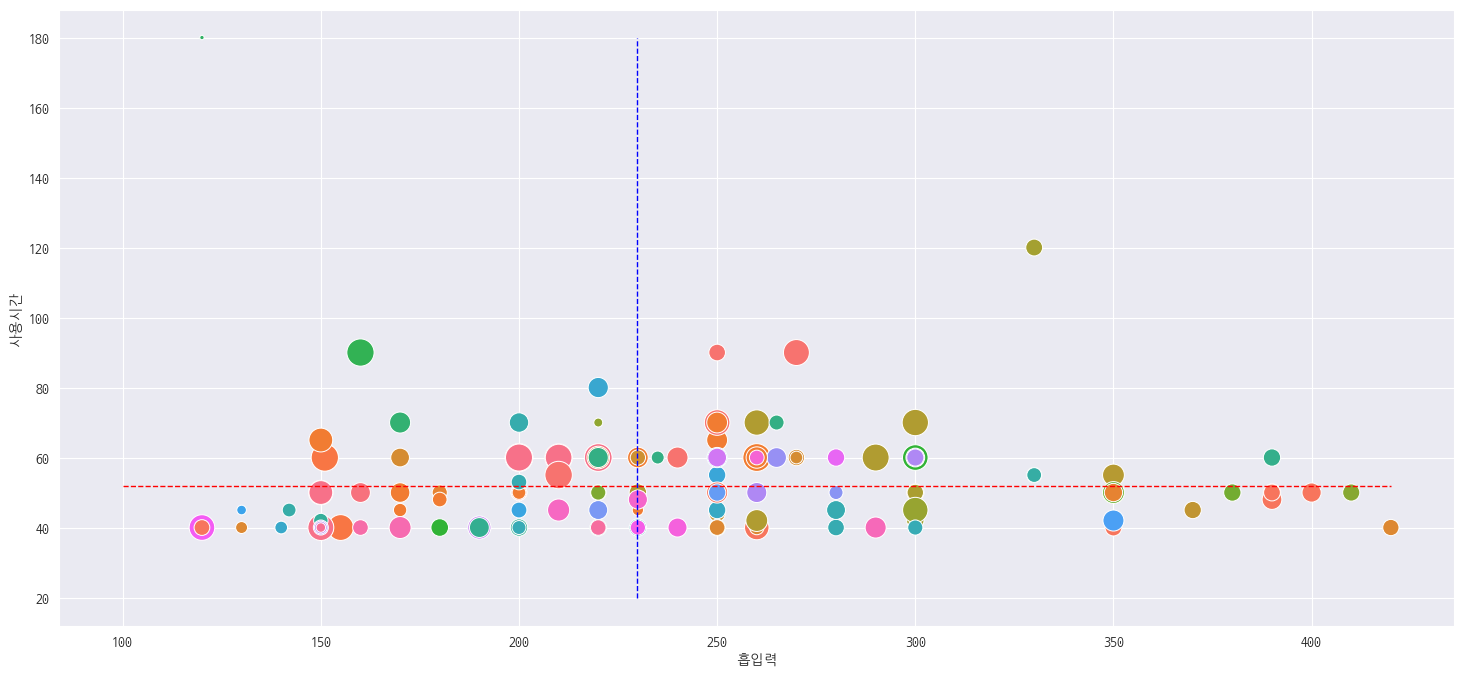

In [120]:
fig = plt.figure(figsize=(18, 8))

sns.scatterplot(data=chartData, x='흡입력', y='사용시간', size='가격', sizes=(10, 400), hue=chartData['회사명'], legend=False)
plt.plot([100, suctionMax], [useTimeMean2, useTimeMean2], 'r--', lw=1) # 사용시간 평균치 줄표시
plt.plot([suctionMean2, suctionMean2], [20, useTimeMax], 'b--', lw=1) # 흡입력 평균치 줄표시
plt.show()

In [113]:
## 인기제품 데이터 시각화
chartDataTop = chartData[:20]

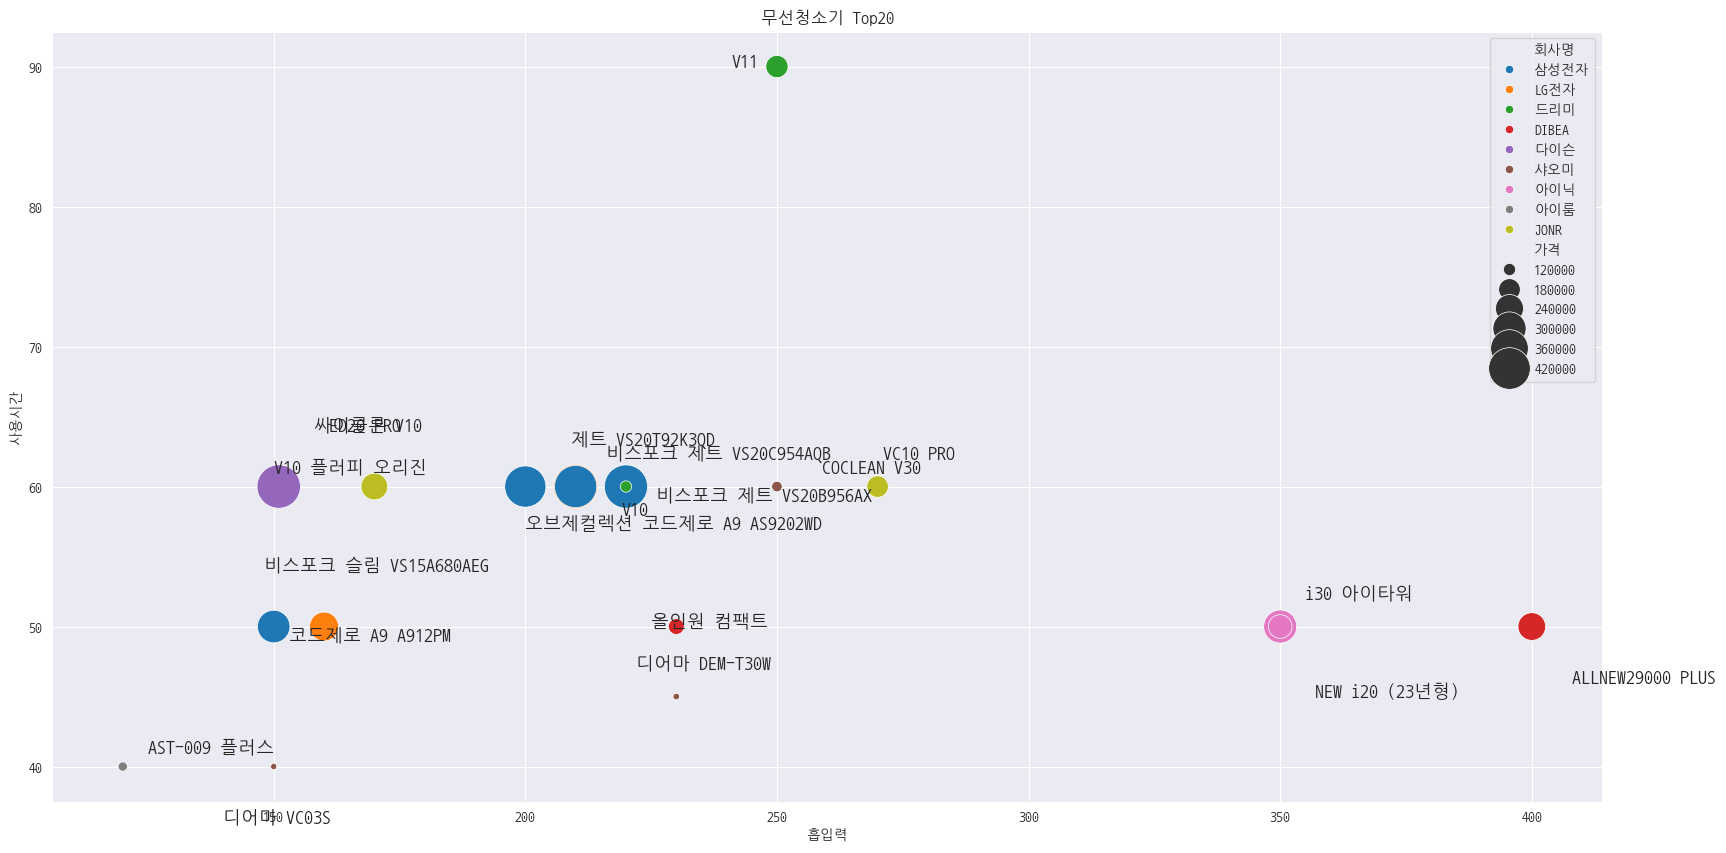

In [114]:
import random

# 인기제품 시각화
fig = plt.figure(figsize=(20, 10))
plt.title('무선청소기 Top20')
sns.scatterplot(data=chartDataTop, x='흡입력', y='사용시간', size='가격', sizes=(20, 1000),
                hue=chartDataTop['회사명'])

for index, row in chartDataTop.iterrows():
    x = row['흡입력'] + random.randrange(-10, 10)
    y = row['사용시간'] + random.randrange(-5, 5)
    s = row['제품명']
    plt.text(x, y, s, size=13)

plt.show()

##### 결론
- 데이터분석을 위한 전처리른 쉽지 않음
- 결과들이 예상이나, 실제와 다를 수 있음